In [1]:
import numpy as np
import pandas as pd
from PIL import Image # 다양한 이미지 파일 형식을 읽고 쓰기 위한 라이브러리
import matplotlib.pyplot as plt
from glob import glob # 파일 이름이나 경로를 기준으로 파일을 찾을 때 사용
import time

import torch # PyTorch : 딥러닝 모델을 구축하고 학습시키기 위한 라이브러리
import torch.nn as nn # 신경망(nn) -> 레이어, 손실 함수 등 구성 요소를 제공하는 모듈
import torch.nn.functional as F # 신경망에서 자주 쓰는 함수 제공
import torch.optim as optim # 신경망에서 자주 쓰는 최적화 알고리즘 제공

from torch.utils.data.sampler import SubsetRandomSampler # 인덱스 list를 받아서 데이터셋의 서브셋을 무작위로 샘플링하는 데 사용
from torch.utils.data import Dataset # 데이터셋을 표현하기 위한 추상 클래스

import torchvision # 컴퓨터 비전 관련 기능을 제공하는 라이브러리 / 미리 학습된 모델, 데이터셋, 이미지 변환 등을 포함
import torchvision.transforms as transforms # 이미지 전처리 및 데이터 증강을 위한 다양한 변환 함수를 제공하는 모듈

# I. Dataset 준비
1. Dataset Class 준비
2. Sampler 준비
3. Data Loader 준비

## 1. Dataset Class 준비
### 1-1) Pytorch의 추상 Dataset 클래스를 상속하여 Dataset 클래스를 생성
* 클래스 기능
  * 이미지를 읽고
  * 이를 Torch Tensor로 변환한 후
  * 변환한 이미지 + label을 반환

In [4]:
# 예외 클래스 정의
class InvalidDatasetException(Exception):
    # 데이터셋의 경로 수 != 레이블 수일 때 에러메시지를 보여줌.
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [6]:
# 이미지를 Tensor 형식으로 변환
transform = transforms.Compose([transforms.ToTensor()]) # 변환 작업 자체를 변수(레고블럭)에 담은 것. 나중에 이 레고블럭 써서 간편하게 조립할 수 있음.

In [8]:
# Data set 클래스 생성 (Pytorch에 내장된 동물 데이터셋을 상속받음)
class AnimalDataset(Dataset):
    
    def __init__(self,img_paths,img_labels,size_of_images):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.size_of_images = size_of_images
        
        # 에러 처리 (위에서 정의한 예외 클래스 이용)
        if len(self.img_paths) != len(self.img_labels):
            raise InvalidDatasetException(self.img_paths,self.img_labels)
        
    
    # 데이터셋 크기를 반환하는 함수 (override)
    def __len__(self):
        return len(self.img_paths)
    
    
    # index를 인수로 받아서 해당 image와 label을 반환하는 함수 (override)
    def __getitem__(self,index):
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images) # 이미지를 읽고
        TENSOR_IMAGE = transform(PIL_IMAGE) # 이를 Torch Tensor로 변환한 후
        label = self.img_labels[index]
        return TENSOR_IMAGE,label # 변환한 이미지 + label을 반환

### 1-2) 1-1에서 만든 클래스로 객체 생성

In [13]:
paths = []
labels = []
label_map = { 0:"Cat",
              1:"Dog",
              2:"Wild"
            }

# 각 class (3개) → 경로와 라벨을 paths, labels(위에서 선언한 변수)애 추가
for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)
    
for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)
    
for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)

# 디버깅
print(len(paths))
print(len(labels))

# 객체 생성
dataset = AnimalDataset(paths,labels,(250,250))

16130
16130


## 2. Sampler 준비
* Sampler → 우리가 어떻게 데이터를 선택하는지 보여줌.
* 우린 주어진 목록에서 인덱스를 무작위로 선택하는 sampler 2개를 사용할 것임.
     * ```Train``` Random Sampler
     * ```Test``` Random Sampler


### 2-1) data set 쪼개고

In [17]:
from sklearn.model_selection import train_test_split # 데이터셋을 훈련 세트와 테스트 세트로 split할 때 사용

dataset_indices = list(range(0,len(dataset))) # [0,1,2,3,..len(dataset)-1]

train_indices,test_indices = train_test_split(dataset_indices,test_size=0.2,random_state=42)

# 디버깅
print("Number of train samples: ",len(train_indices))
print("Number of test samples: ",len(test_indices))

Number of train samples:  12904
Number of test samples:  3226


### 2-2) sampler 생성

In [19]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

## 3. Data Loader 준비
* Data loader
    * 1에서 만든 data set과
    * 2에서 만든 sampler를 사용하여
    * mini batch들을 생성함. 
    * 그럼 나중에 data loader(= 여러 batch 목록)를 사용해서 batch를 하나씩 불러올 수 있음.
* sampler가 train, test 해서 2개였으니까 → data loader도 그렇게 2개.

In [20]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader( dataset,  batch_size=BATCH_SIZE,  sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(  dataset,  batch_size=BATCH_SIZE,  sampler=test_sampler)

## (+) 데이터 눈으로 확인하기

In [21]:
dataset[1][0].shape

torch.Size([3, 250, 250])

In [30]:
images,labels = next(iter(train_loader)) # iter 함수 : train_loader의 첫번째 원소(첫번째 mini batch)를 가리키는 반복자를 반환 / next 함수 : 반복자를 인수로 받아서 첫번째 호출됐을 때는 그 반복자, 두번째에는 다음 반복자, 세번째에는 또 그다음 반복자가 가리키는 곳을 반환함
type(labels) # 첫 번째 mini batch의 images, labels 중 labels의 type은?

torch.Tensor

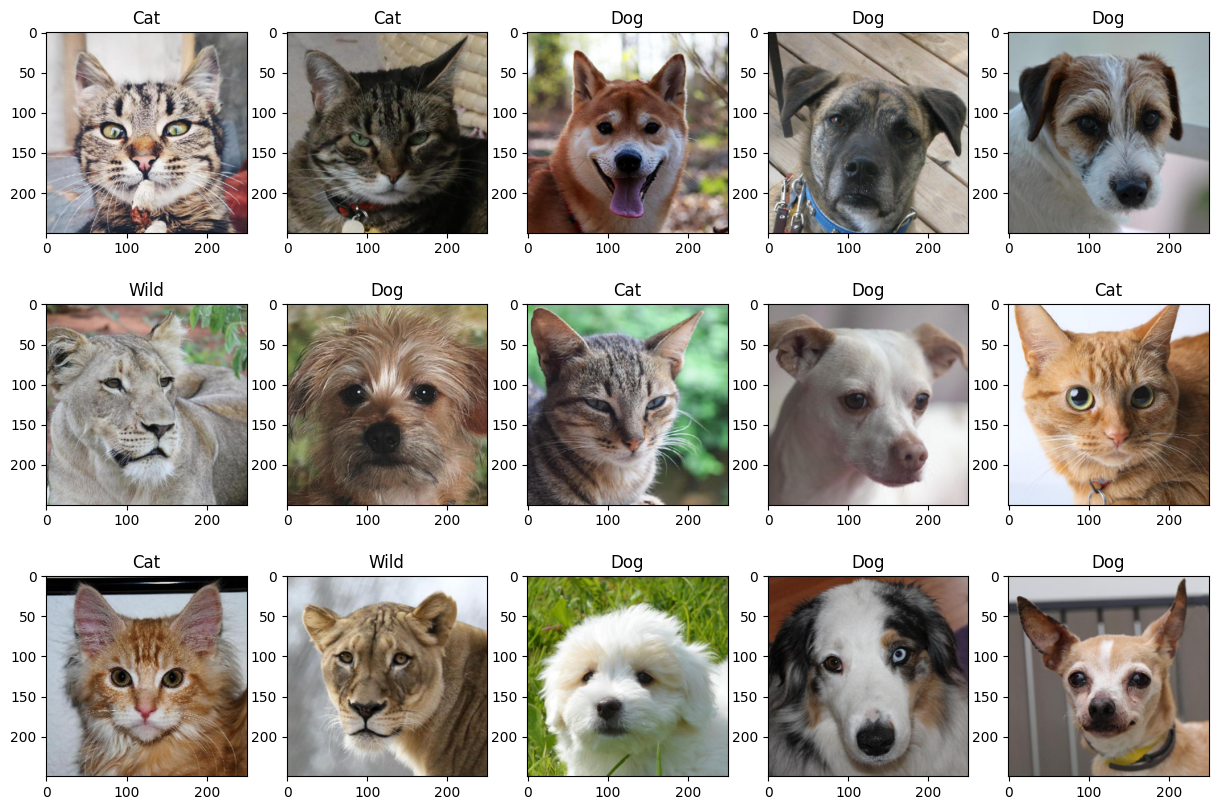

In [34]:
images,labels = next(iter(train_loader)) # 이번에는 두 번째 mini batch를 반환하겠지. 이 코드를 여러 번 실행하면 세 번째, 네 번째... 이렇게 될 거고.

# batch를 시각화
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title = f"{label}")

# II. 신경망 모델링
1. 모델 생성
2. 모델 학습시키기 (Training Model)
3. Test

## 1. 모델 생성
### 1-1) CNN 클래스 생성
* Pytorch의 nn.Module 추상 클래스를 상속받고,
* layer 쌓아서 모델 지정하기 (=순전파 정의하기. 역전파랑 가중치 업뎃은 알아서 됨.)

In [43]:
class CNN(nn.Module):
    
    # 생성자 : layer 정의하기
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256 * 2 * 2,512)
        self.fc2 = nn.Linear(512,3)
     
    
    # 순전파 : 생성자에서 정의한 layer를 실제로 사용하기 (데이터 통과시키기)
    def forward(self,x):
        # layer 1
        x = F.relu(self.conv1(x)) # 합성곱 층
        
        # layer 2
        x = F.relu(self.conv2(x)) # 합성곱 층
        x = self.batchnorm1(x) # 배치 정규화 (Batch Normalization)
        x = self.maxpool(x) # 풀링 층
        
        # layer 3
        x = F.relu(self.conv3(x)) # 합성곱 층
        x = self.batchnorm2(x) # 배치 정규화
        x = self.maxpool(x) # 풀링 층
        
        # layer 4
        x = F.relu(self.conv4(x)) # 합성곱 층
        x = self.batchnorm3(x) # 배치 정규화
        x = self.maxpool(x) # 풀링 층
        
        # layer 후반부
        x = x.view(-1, 256 * 2 * 2) # view 메소드 : 텐서 재배열
        x = self.fc1(x) # FC 층
        x = self.fc2(x) # FC 층
        x = F.log_softmax(x,dim=1) # softmax 층
        
        return x  

### 1-2) 모델 객체 생성

In [44]:
# GPU 쓸지 CPU 쓸지
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 디버깅
device

device(type='cpu')

In [45]:
# 모델 객체 선언
model = CNN().to(device) # CNN 객체를 GPU(또는 CPU)로 보냄.

### 1-3) loss / 최적화 알고리즘 지정
* 교차 엔트로피 loss
* RMSProp 최적화 알고리즘

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

## 2. 모델 학습시키기 (Training Model)

In [ ]:
TRAIN_LOSS = []
TRAIN_ACCURACY = []

EPOCH_NUMBER = 5

# 각 epoch에 대해
for epoch in range(1,EPOCH_NUMBER+1):
    # 초기화
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # 각 mini batch에 대해
    for data_,target_ in train_loader: 
        
        # image와 label을 device(GPU 또는 CPU)로 보내기
        data_ = data_.to(device) # image
        target_ = target_.to(device) # label
        
        # 가중치 초기화
        optimizer.zero_grad()
        
        # 순전파 / loss 계산
        outputs = model(data_) # 순전파
        loss = criterion(outputs,target_)
        
        # 역전파, 가중치 업뎃
        loss.backward()
        optimizer.step()
        
        # 통계 계산
        epoch_loss += loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
    
    # 각 epoch의 통계 → 저장, 출력
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch}: Accuracy: {100 * correct/total}, Loss: {epoch_loss}")

    
# 전체 epoch의 통계 → 그래프로 출력
plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_LOSS,color="blue",label="Loss")
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_ACCURACY,color="green",label="Accuracy")
plt.legend()
plt.show()

Epoch 1: Accuracy: 90.87104773713577, Loss: 25.6966834962368


## 3. Test

In [ ]:
total_val_loss = 0.0
total_true = 0
total = len(test_sampler)

# When we're not working with gradients and backpropagation
# we use torch.no_grad() utility.
with torch.no_grad():
    model.eval()
    for data_,target_ in validation_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)
        
        outputs = model(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        total_val_loss += loss
        true = torch.sum(preds == target_).item()
        total_true += true

validation_accuracy = round(100 * total_true / total,2)
print(f"Validation accuracy: {validation_accuracy}%")
print(f"Validation loss: {round(total_val_loss,2)}%")

# III. 모델 저장하기
* 한 번 학습시켜놓고, 학습한 모델을 저장하면 나중에 계속 쓸 수 있음.
* 저장하는 방법은 다양함.
  * 우리가 사용할 방법 → state dict를 저장

## (+) state dict 출력해서 확인하기

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

## 1. state dict를 "model.pt" 파일에 저장하기

In [ ]:
torch.save(model.state_dict(),"model.pt")

## 2. 저장한 모델 불러오기
### 2-1) 모델 객체 선언하기
### 2-2) state dict를 load하기

In [ ]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("model.pt"))